<a href="https://colab.research.google.com/github/rrl7012005/TF-NLP/blob/main/Neural_Machine_Translation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Attention Based Encoder Decoder

We will translate spanish to English using an attention based encoder decoder model.

We need tensorflow-text and einops

In [ ]:
!pip install tensorflow-text
!pip install einops

Einops is a library for tensor operations, specifically splicing and those sorts.

In [ ]:
import numpy as np
import typing
from typing import Any, Tuple

import einops

import matplotlib.pyplot as plt
import matplotlib

import tensorflow as tf
import tensorflow_text as tf_text

The language dataset is provided by Anki where translation pairs are in the format

May I borrow this book? ¿Puedo tomar prestado este libro?

##Data Downloading and Preparation

After that we need to add start and end tokens. Clean sentences by removing special characters. Create a word index mapping and pad each sentence to a maximum length.

In [ ]:
import pathlib

path_to_zip = tf.keras.utils.get_file('spa-eng-zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True)

path_to_file = pathlib.Path(path_to_zip).parent/'spa-eng/spa.txt'

path_to_file

2638744/2638744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


PosixPath('/root/.keras/datasets/spa-eng/spa.txt')

In [ ]:
x = path_to_file.read_text(encoding='utf-8')
x[:500]

'Go.\tVe.\nGo.\tVete.\nGo.\tVaya.\nGo.\tVáyase.\nHi.\tHola.\nRun!\t¡Corre!\nRun.\tCorred.\nWho?\t¿Quién?\nFire!\t¡Fuego!\nFire!\t¡Incendio!\nFire!\t¡Disparad!\nHelp!\t¡Ayuda!\nHelp!\t¡Socorro! ¡Auxilio!\nHelp!\t¡Auxilio!\nJump!\t¡Salta!\nJump.\tSalte.\nStop!\t¡Parad!\nStop!\t¡Para!\nStop!\t¡Pare!\nWait!\t¡Espera!\nWait.\tEsperen.\nGo on.\tContinúa.\nGo on.\tContinúe.\nHello!\tHola.\nI ran.\tCorrí.\nI ran.\tCorría.\nI try.\tLo intento.\nI won!\t¡He ganado!\nOh no!\t¡Oh, no!\nRelax.\tTomátelo con soda.\nSmile.\tSonríe.\nAttack!\t¡Al ataque!\nAttack!\t¡Atacad!\nGe'

As you can see each line contains one sequence, where the english and spanish sequences are separated by a tab

Split the english and spanish sentences

In [ ]:
def load_data(path):
  text = path.read_text(encoding='utf-8')

  lines = text.splitlines()
  pairs = [line.split('\t') for line in lines]

  context = np.array([context for target, context in pairs])
  target = np.array([target for target, context in pairs])

  return target, context

Recall our target is the english sentence. The way our dataset is is that first it sees words then as you go down you see more complicated phrases, best way to learn translation.

In [ ]:
target_raw, context_raw = load_data(path_to_file)
print(context_raw[-1])
print(target_raw[-1])

Si quieres sonar como un hablante nativo, debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un músico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado.
If you want to sound like a native speaker, you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo.


Now lets create a tf Dataset and create train val splits. Randomly pick 80% of the dataset, well each element has an 80% chance of being picked.

~is_train is basically where its false

In [ ]:
BUFFER_SIZE = len(context_raw)
BATCH_SIZE = 64

is_train = np.random.uniform(size=(len(target_raw),)) < 0.8

train_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[is_train], target_raw[is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))

val_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[~is_train], target_raw[~is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))

len(train_raw), len(val_raw)

(1488, 372)

Inspect the dataset

In [ ]:
for example_context_strings, example_target_strings in train_raw.take(1):
  print(example_context_strings[:5])
  print()
  print(example_target_strings[:5])
  break

tf.Tensor(
[b'El promueve una revisi\xc3\xb3n de las reglas.'
 b'Ella estaba vestida de rojo.' b'Tenemos que rehacer este informe.'
 b'El cliente siempre lleva raz\xc3\xb3n.'
 b'Tengo que devolver el libro antes del s\xc3\xa1bado.'], shape=(5,), dtype=string)

tf.Tensor(
[b'He advocates a revision of the rules.' b'She was dressed in red.'
 b'We need to do this report again.' b'The customer is always right.'
 b'I have to give back the book before Saturday.'], shape=(5,), dtype=string)


##Vectorization

Now the model has multilingual text with a limited vocabulary, so its important to standardize the input text.

Text comes in many forms, accented characters, different encodings, standardizing ensures similar inputs are treated the same way. We convert characters to a common form.

The first step is to do Unicode normalization to split accented characters and replace with their ASCII equivalents.

This normalization is different from (making it in range 0 to 1), this is ensuring words like cafe and cafe' have same meaning.

In [ ]:
example_text = tf.constant('¿Todavía está en casa?')

print(example_text.numpy())
print(tf_text.normalize_utf8(example_text, 'NFKD').numpy())

b'\xc2\xbfTodav\xc3\xada est\xc3\xa1 en casa?'
b'\xc2\xbfTodavi\xcc\x81a esta\xcc\x81 en casa?'


We also keep spaces, certain punctuation, characters a to z. Add spaces around punctuatuon so we can split, convert to lowercase, and remove whitespaces. Cleaning our data essentially.

In [ ]:
def tf_lower_and_split_punct(text):

  # Split accented characters.
  text = tf_text.normalize_utf8(text, 'NFKD')
  text = tf.strings.lower(text)

  # Keep space, a to z, and select punctuation.
  text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')

  # Add spaces around punctuation.
  text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')

  # Strip whitespace.
  text = tf.strings.strip(text)

  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text

print(example_text.numpy().decode())
print(tf_lower_and_split_punct(example_text).numpy().decode())

¿Todavía está en casa?
[START] ¿ todavia esta en casa ? [END]


The standardization function will be wrapped in a vectorization layer which will effectively deal with tokens and one hot encoding. Its ragged tensors as sizes may be different.

In [ ]:
max_vocab_size = 5000

context_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

target_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

context_text_processor.adapt(train_raw.map(lambda context, target: context))

target_text_processor.adapt(train_raw.map(lambda context, target: target))


context_text_processor.get_vocabulary()[:10], target_text_processor.get_vocabulary()[:10]

(['', '[UNK]', '[START]', '[END]', '.', 'que', 'de', 'el', 'a', 'no'],
 ['', '[UNK]', '[START]', '[END]', '.', 'the', 'i', 'to', 'you', 'tom'])

Now can convert a batch of strings to a batch of token IDs

In [ ]:
example_tokens = context_text_processor(example_context_strings)
example_tokens[:3, :]

<tf.RaggedTensor [[2, 7, 1, 23, 1, 6, 33, 921, 4, 3], [2, 29, 47, 3322, 6, 907, 4, 3],
 [2, 158, 5, 1, 40, 1810, 4, 3]]>

In [ ]:
context_vocab = np.array(context_text_processor.get_vocabulary())

tokens = context_vocab[example_tokens[0].numpy()]
' '.join(tokens)

'[START] el [UNK] una [UNK] de las reglas . [END]'

The returned token ids are automatically zero padded.

Text(0.5, 1.0, 'Mask')

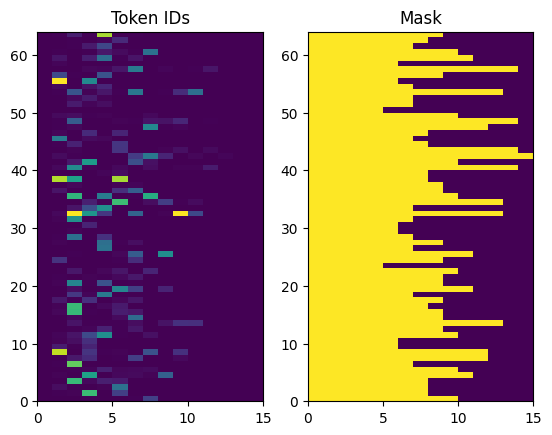

In [ ]:
plt.subplot(1, 2, 1)
plt.pcolormesh(example_tokens.to_tensor())
plt.title('Token IDs')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens.to_tensor() != 0)
plt.title('Mask')

Now lets create a function to convert the datasets of strings into 0 padded tensors of token ids, and each (context, target) pair to a (context, target_in), target_out for training. Recall the decoding process is autoregressive. We use AUTOTUNE.

In [ ]:
def process_text(context, target):
  context = context_text_processor(context).to_tensor()
  target = target_text_processor(target)
  targ_in = target[:,:-1].to_tensor()
  targ_out = target[:,1:].to_tensor()
  return (context, targ_in), targ_out


train_ds = train_raw.map(process_text, tf.data.AUTOTUNE)
val_ds = val_raw.map(process_text, tf.data.AUTOTUNE)

In [ ]:
for (ex_context_tok, ex_tar_in), ex_tar_out in train_ds.take(1):
  print(ex_context_tok.shape)
  print(ex_tar_in.shape)
  print(ex_context_tok[0, :10].numpy())
  print()
  print(ex_tar_in[0, :10].numpy())
  print(ex_tar_out[0, :10].numpy())

(64, 19)
(64, 15)
[ 2 52  1 19 48 79  1  4  3  0]

[  2  68   6 589  18   6  37   7  35   1]
[ 68   6 589  18   6  37   7  35   1   4]


##Modelling

The goal of the encoder is to process the context sequence into a sequence of vectors that are useful for the decoder as it attempts to predict the next output **FOR EACH TIMESTEP**. Attend at each timestep. We use a BiRNN as the context sequence is constant, no info flow, and we will use GRU layers, with xavier initialization. (Wont really need long term memory so no need LSTM).

The merge mode of the bidirectionals here are not concatenating but summed to give a combined representation that maintains the scale.

In [ ]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, text_processor, units):
    super(Encoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(self.vocab_size, units,
                                               mask_zero=True) #pad

    self.rnn = tf.keras.layers.Bidirectional(
        merge_mode = 'sum',
        layer=tf.keras.layers.GRU(units, return_sequences=True,
                                  recurrent_initializer='glorot_uniform')
    )

  def call(self, x):
    x = self.embedding(x)
    x = self.rnn(x)

    return x

  #Convert random text to ready for input
  def convert_input(self, texts):
    texts = tf.convert_to_tensor(texts)

    #Converts scalars to 1D tensors
    if len(texts.shape) == 0:
      texts = tf.convert_to_tensor(texts)[tf.newaxis]

    context = self.text_processor(texts).to_tensor()
    context = self(context)
    return context

Test it

In [ ]:
UNITS = 256

encoder = Encoder(context_text_processor, UNITS)
ex_context = encoder(ex_context_tok)

print(f'Context tokens, shape (batch, s): {ex_context_tok.shape}')
print(f'Encoder output, shape (batch, s, units): {ex_context.shape}')

Context tokens, shape (batch, s): (64, 19)
Encoder output, shape (batch, s, units): (64, 19, 256)


**Cross Attention Layer**

At each timestep we attend over the input sequence.

The MHA layer takes the number of heads, the key dimension (same as query dim).

Recall in these encoder models, the query is the information from the word generated so far (see Cam notes) so its cross attention.

In [ ]:
class CrossAttention(tf.keras.layers.Layer):
  def __init__(self, units, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(key_dim=units, num_heads=1, **kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

  def call(self, x, context):
    attn_output, attn_scores = self.mha(query=x, value=context,
                                        return_attention_scores=True)

    #Average over each head
    attn_scores = tf.reduce_mean(attn_scores, axis=1)
    self.last_attention_weights = attn_scores

    #Add a residual block
    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

In [ ]:
attention_layer = CrossAttention(UNITS)

embed = tf.keras.layers.Embedding(target_text_processor.vocabulary_size(),
                                  output_dim=UNITS, mask_zero=True)

ex_tar_embed = embed(ex_tar_in)

result = attention_layer(ex_tar_embed, ex_context)

print(f'Context sequence, shape (batch, s, units): {ex_context.shape}')
print(f'Target sequence, shape (batch, t, units): {ex_tar_embed.shape}')
print(f'Attention result, shape (batch, t, units): {result.shape}')
print(f'Attention weights, shape (batch, t, s):    {attention_layer.last_attention_weights.shape}')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'query' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'key' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'value' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Context sequence, shape (batch, s, units): (64, 19, 256)
Target sequence, shape (batch, t, units): (64, 15, 256)
Attention result, shape (batch, t, units): (64, 15, 256)
Attention weights, shape (batch, t, s):    (64, 15, 19)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'cross_attention' (of type CrossAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Attention weights sum to 1

In [ ]:
attention_layer.last_attention_weights[0].numpy().sum(axis=-1)

array([1.        , 1.        , 1.        , 0.99999994, 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 0.99999994, 0.99999994, 0.99999994, 0.99999994],
      dtype=float32)

We can plot the attention weights across the context sequences at t=0

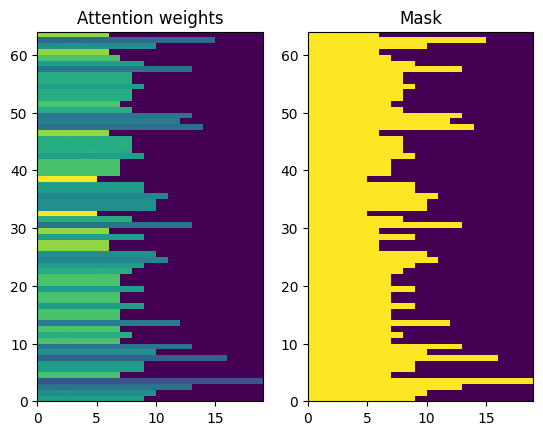

In [ ]:
attention_weights = attention_layer.last_attention_weights
mask=(ex_context_tok != 0).numpy()

plt.subplot(1, 2, 1)
plt.pcolormesh(mask*attention_weights[:, 0, :])
plt.title('Attention weights')

plt.subplot(1, 2, 2)
plt.pcolormesh(mask)
plt.title('Mask');

**Decoder**

The decoder is a RNN so not directly an autoregressive process but uses a hidden state to keep track of whats been generated so far. An elma not a jordan network. The call method takes 3 args, inputs is (context, x), state is the previous state output from the decoder (hidden state of rnn), to continue generating text from where you left off, and return_state a boolean to return rnn hidden state. So we can generate sentence on top of sentence.

Now for inference we need a couple more methods. get_initial_state which gets the initial state, tokens_to_text which converts tokens to text and get_next_token which starts this generative process.

In [ ]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, text_processor, units):
    super(Decoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()

    #A thing converting words to ids
    self.word_to_id = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]')

    #out of vocab token is unk. Theres no masking.
    #just invert prev lookup
    self.id_to_word = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]',
        invert=True)

    self.start_token = self.word_to_id('[START]')
    self.end_token = self.word_to_id('[END]')

    self.units = units

    self.embedding = tf.keras.layers.Embedding(self.vocab_size,
                                               units, mask_zero=True)

    self.rnn = tf.keras.layers.GRU(units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

    self.attention = CrossAttention(units)

    self.output_layer = tf.keras.layers.Dense(self.vocab_size)

  def call(self, context, x, state=None, return_state=False):
    x = self.embedding(x)
    x, state = self.rnn(x, initial_state=state)

    x = self.attention(x, context)
    self.last_attention_weights = self.attention.last_attention_weights

    logits = self.output_layer(x)

    if return_state:
      return logits, state
    else:
      return logits


  def get_initial_state(self, context):
    batch_size = tf.shape(context)[0]
    start_tokens = tf.fill([batch_size, 1], self.start_token)
    done = tf.zeros([batch_size, 1], dtype=tf.bool)
    embedded = self.embedding(start_tokens)
    return start_tokens, done, self.rnn.get_initial_state(batch_size=batch_size)[0]

  def tokens_to_text(self, tokens):
    words = self.id_to_word(tokens)
    result = tf.strings.reduce_join(words, axis=-1, separator=' ')
    result = tf.strings.regex_replace(result, '^ *\[START\] *', '')
    result = tf.strings.regex_replace(result, ' *\[END\] *$', '')
    return result

  def get_next_token(self, context, next_token, done, state, temperature = 0.0):
    logits, state = self(
      context, next_token,
      state = state,
      return_state=True)

    #High temp, probs close together, distribution more even

    if temperature == 0.0:
      next_token = tf.argmax(logits, axis=-1)
    else:
      logits = logits[:, -1, :]/temperature
      next_token = tf.random.categorical(logits, num_samples=1)

    done = done | (next_token == self.end_token)

    # Once a sequence is done it only produces 0-padding.
    next_token = tf.where(done, tf.constant(0, dtype=tf.int64), next_token)

    return next_token, done, state

decoder = Decoder(target_text_processor, UNITS)

In training the decoder will be used to predict the next target token for each target token.

In [ ]:
logits = decoder(ex_context, ex_tar_in)

print(f'encoder output shape: (batch, s, units) {ex_context.shape}')
print(f'input target tokens shape: (batch, t) {ex_tar_in.shape}')
print(f'logits shape shape: (batch, target_vocabulary_size) {logits.shape}')

ValueError: Exception encountered when calling Decoder.call().

[1mtoo many values to unpack (expected 2)[0m

Arguments received by Decoder.call():
  • context=tf.Tensor(shape=(64, 19, 256), dtype=float32)
  • x=tf.Tensor(shape=(64, 15), dtype=int64)
  • state=None
  • return_state=False

We can write a loop for text generation, ofcourse its random for now.

In [ ]:
next_token, done, state = decoder.get_initial_state(ex_context)
tokens = []

for n in range(10):

  next_token, done, state = decoder.get_next_token(
      ex_context, next_token, done, state, temperature=1.0)

  tokens.append(next_token)

tokens = tf.concat(tokens, axis=-1) # (batch, t)

# Convert the tokens back to a a string
result = decoder.tokens_to_text(tokens)
result[:3].numpy()

**Translater**

Now lets combine the encoder and decoder, and a translate function for inference

In [ ]:
class Translator(tf.keras.Model):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun
  def __init__(self, units=256,
               context_text_processor=None,
               target_text_processor=None):
    super().__init__()
    encoder = Encoder(context_text_processor, units)
    decoder = Decoder(target_text_processor, units)

    self.encoder = encoder
    self.decoder = decoder

  def call(self, inputs):
    context, x = inputs
    context = self.encoder(context)
    logits = self.decoder(context, x)

    try:
      del logits._keras_mask
    except AttributeError:
      pass

    return logits

  def translate(self,
              texts, *,
              max_length=50,
              temperature=0.0):

    # Process the input texts
    context = self.encoder.convert_input(texts)
    batch_size = tf.shape(texts)[0]

    # Setup the loop inputs
    tokens = []
    attention_weights = []
    next_token, done, state = self.decoder.get_initial_state(context)

    for _ in range(max_length):

      # Generate the next token
      next_token, done, state = self.decoder.get_next_token(
          context, next_token, done,  state, temperature)

      # Collect the generated tokens
      tokens.append(next_token)
      attention_weights.append(self.decoder.last_attention_weights)

      if tf.executing_eagerly() and tf.reduce_all(done):
        break

    # Stack the lists of tokens and attention weights.
    tokens = tf.concat(tokens, axis=-1)   # t*[(batch 1)] -> (batch, t)
    self.last_attention_weights = tf.concat(attention_weights, axis=1)  # t*[(batch 1 s)] -> (batch, t s)

    result = self.decoder.tokens_to_text(tokens)
    return result


In [ ]:
model = Translator(UNITS, context_text_processor, target_text_processor)

logits = model((ex_context_tok, ex_tar_in))

print(f'Context tokens, shape: (batch, s, units) {ex_context_tok.shape}')
print(f'Target tokens, shape: (batch, t) {ex_tar_in.shape}')
print(f'logits, shape: (batch, t, target_vocabulary_size) {logits.shape}')

##Training

In [ ]:
def masked_loss(y_true, y_pred):
  loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')
  loss = loss_fn(y_true, y_pred)

  #Mask off the losses on the padding
  mask = tf.cast(y_true != 0, loss.dtype)
  loss *= mask

  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss

def masked_acc(y_true, y_pred):

    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)

    match = tf.cast(y_true == y_pred, tf.float32)
    mask = tf.cast(y_true != 0, tf.float32)

    return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [ ]:
model.compile(optimizer='adam',
              loss=masked_loss,
              metrics=[masked_acc, masked_loss])

Initially, the model should roughly uniform output probabilities, so we expect the loss and acc to be

In [ ]:
vocab_size = 1.0 * target_text_processor.vocabulary_size()

{"expected_loss": tf.math.log(vocab_size).numpy(),
 "expected_acc": 1/vocab_size}

In [ ]:
model.evaluate(val_ds, steps=20, return_dict=True)

We repeat the training set forever, and the model will see 100 batches it will designate as epoch. Also we place a max of 100 epochs. The model will evaluate on 20 batches from the validation set.

In [ ]:
history = model.fit(
    train_ds.repeat(),
    epochs=100,
    steps_per_epoch = 100,
    validation_data=val_ds,
    validation_steps = 20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3)])

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()
plt.show()

plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()
plt.show()

##Predicting

In [ ]:
def translate(self,
              texts, *,
              max_length=50,
              temperature=0.0):

    # Process the input texts
    context = self.encoder.convert_input(texts)
    batch_size = tf.shape(texts)[0]

    # Setup the loop inputs
    tokens = []
    attention_weights = []
    next_token, done, state = self.decoder.get_initial_state(context)

    for _ in range(max_length):

      # Generate the next token
      next_token, done, state = self.decoder.get_next_token(
          context, next_token, done,  state, temperature)

      # Collect the generated tokens
      tokens.append(next_token)
      attention_weights.append(self.decoder.last_attention_weights)

      if tf.executing_eagerly() and tf.reduce_all(done):
        break

    # Stack the lists of tokens and attention weights.
    tokens = tf.concat(tokens, axis=-1)   # t*[(batch 1)] -> (batch, t)
    self.last_attention_weights = tf.concat(attention_weights, axis=1)  # t*[(batch 1 s)] -> (batch, t s)

    result = self.decoder.tokens_to_text(tokens)
    return result

In [ ]:
result = model.translate(['¿Todavía está en casa?']) # Are you still home
result[0].numpy().decode()

Lets make code to plot the attention

In [ ]:
@Translator.add_method
def plot_attention(self, text, **kwargs):
  assert isinstance(text, str)
  output = self.translate([text], **kwargs)
  output = output[0].numpy().decode()

  attention = self.last_attention_weights[0]

  context = tf_lower_and_split_punct(text)
  context = context.numpy().decode().split()

  output = tf_lower_and_split_punct(output)
  output = output.numpy().decode().split()[1:]

  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(1, 1, 1)

  ax.matshow(attention, cmap='viridis', vmin=0.0)

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + output, fontdict=fontdict)

  ax.xaxis.set_major_locator(matplotlib.Ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(matplotlib.Ticker.MultipleLocator(1))

  ax.set_xlabel('Input text')
  ax.set_ylabel('Output text')

Lets translate and plot attentions

In [ ]:
model.plot_attention('¿Todavía está en casa?') #Are you still home

In [ ]:
# This is my life.
model.plot_attention('Esta es mi vida.')

In [ ]:
 # Try to find out.'
model.plot_attention('Tratar de descubrir.')

The short sentences often work well however if we use long inputs, the model fails because of GRUs, the model only has access to previous output via RNN state so RNN loses track, so use Transformers, which lets the decoder look at what its output so far. The model was also trained with teacher forcing feeding the correct token at each step regarding of the model's prediction. The model could be made more robust if it were sometimes fed its own predictions.

The raw data is sorted by length so lets translate the longest sequence.

In [ ]:
long_text = context_raw[-1]

import textwrap
print('Expected output:\n', '\n'.join(textwrap.wrap(target_raw[-1])))

In [ ]:
model.plot_attention(long_text)

The translate function works on batches

In [ ]:
%%time

inputs = [
    'Hace mucho frio aqui.', # "It's really cold here."
    'Esta es mi vida.', # "This is my life."
    'Su cuarto es un desastre.' # "His room is a mess"
]

result = model.translate(inputs)

print(result[0].numpy().decode())
print(result[1].numpy().decode())
print(result[2].numpy().decode())
print()

Now lets export the model, if we do, wrap the translate method in a tf function to put it in graph mode.

In [ ]:
class Export(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
  def translate(self, inputs):
    return self.model.translate(inputs)

export = Export(model)

#Run it once so its compiled
_ = export.translate(tf.constant(inputs))

In [ ]:
%%time

result = export.translate(tf.constant(inputs))

print(result[0].numpy().decode())
print(result[1].numpy().decode())
print(result[2].numpy().decode())
print()

Now its been traced so its much faster, and the function can be exported using saved_model.save

In [ ]:
tf.saved_model.save(export, 'translator',
                    signatures={'serving_default': export.translate})

In [ ]:
reloaded = tf.saved_model.load('translator')
_ = reloaded.translate(tf.constant(inputs)) #Trace

#Go

result = reloaded.translate(tf.constant(inputs))

print(result[0].numpy().decode())
print(result[1].numpy().decode())
print(result[2].numpy().decode())
print()

#Transfomers

Now we will translate Portuguese into English.

In [ ]:
!pip install protobuf~=3.20.3
!pip install -q tensorflow_datasets
!pip install -q -U tensorflow-text

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 37.3 MB/s eta 0:00:00


In [ ]:
import logging
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import tensorflow as tf

import tensorflow_text

##Data Loading & Inspection

In [ ]:
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en', with_info=True,
                               as_supervised=True)

train_examples, val_examples = examples['train'], examples['validation']

train_examples, val_examples

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/51785 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/incomplete.IWDHD5_1.0.0/ted_hrlr_translate-tra…

Generating validation examples...:   0%|          | 0/1193 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/incomplete.IWDHD5_1.0.0/ted_hrlr_translate-val…

Generating test examples...:   0%|          | 0/1803 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/incomplete.IWDHD5_1.0.0/ted_hrlr_translate-tes…

Dataset ted_hrlr_translate downloaded and prepared to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0. Subsequent calls will reuse this data.


(<_PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))>)

This is a dataset object, decode the strings into utf-8

In [ ]:
for pt_examples, en_examples in train_examples.batch(3).take(1):
  print(' > Portuguese Examples: ')
  for pt in pt_examples.numpy():
    print(pt.decode('utf-8'))

  print()

  print('> Examples in English: ')

  for en in en_examples.numpy():
    print(en.decode('utf-8'))

 > Portuguese Examples: 
e quando melhoramos a procura , tiramos a única vantagem da impressão , que é a serendipidade .
mas e se estes fatores fossem ativos ?
mas eles não tinham a curiosidade de me testar .

> Examples in English: 
and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n't test for curiosity .


The tokenizer we will use will be the BERT tokenizer used in BERT model.

In [ ]:
model_name = 'ted_hrlr_translate_pt_en_converter'

tf.keras.utils.get_file(
    f'{model_name}.zip',
    f'https://storage.googleapis.com/download.tensorflow.org/models/{model_name}.zip',
    cache_dir='.', cache_subdir='', extract=True
)

184801/184801 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


'./ted_hrlr_translate_pt_en_converter.zip'

In [ ]:
tokenizers = tf.saved_model.load(model_name)

This moodel contains 2 text tokenizers, one for English, one for Portuguese. Both have the same method. The following code that filters and returns a list of all methods, attributes in the tokenizers.en module, excluding those starting with underscores.

In [ ]:
[item for item in dir(tokenizers.en) if not item.startswith('_')]

['detokenize',
 'get_reserved_tokens',
 'get_vocab_path',
 'get_vocab_size',
 'lookup',
 'tokenize',
 'tokenizer',
 'vocab']

In [ ]:
print('> This is a batch of strings:')

for en in en_examples.numpy():
  print(en.decode('utf-8'))

> This is a batch of strings:
and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n't test for curiosity .


See the encoded batch

In [ ]:
encoded = tokenizers.en.tokenize(en_examples)

print('> This is a padded-batch of token IDs: ')
for row in encoded.to_list():
  print(row)

> This is a padded-batch of token IDs: 
[2, 72, 117, 79, 1259, 1491, 2362, 13, 79, 150, 184, 311, 71, 103, 2308, 74, 2679, 13, 148, 80, 55, 4840, 1434, 2423, 540, 15, 3]
[2, 87, 90, 107, 76, 129, 1852, 30, 3]
[2, 87, 83, 149, 50, 9, 56, 664, 85, 2512, 15, 3]


There is a detokenize method which attempts to convert these token IDs back to human readable text.

In [ ]:
round_trip = tokenizers.en.detokenize(encoded)

print('> This is human-readable text:')
for line in round_trip.numpy():
  print(line.decode('utf-8'))

> This is human-readable text:
and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n ' t test for curiosity .


There is a lower level lookup method that converts from token IDs to token text.

In [ ]:
print('> This is the text split into tokens:')
tokens = tokenizers.en.lookup(encoded)
tokens

> This is the text split into tokens:


<tf.RaggedTensor [[b'[START]', b'and', b'when', b'you', b'improve', b'search', b'##ability',
  b',', b'you', b'actually', b'take', b'away', b'the', b'one', b'advantage',
  b'of', b'print', b',', b'which', b'is', b's', b'##ere', b'##nd', b'##ip',
  b'##ity', b'.', b'[END]']                                                 ,
 [b'[START]', b'but', b'what', b'if', b'it', b'were', b'active', b'?',
  b'[END]']                                                           ,
 [b'[START]', b'but', b'they', b'did', b'n', b"'", b't', b'test', b'for',
  b'curiosity', b'.', b'[END]']                                          ]>

As you can see this is sub word units. Indicated by ##ere, ##nd etc. We can see the distribution of tokens per example.

...................................................

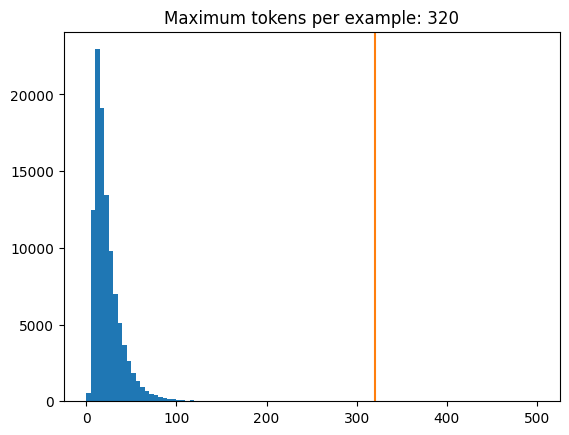

In [ ]:
lengths = []

for pt_examples, en_examples in train_examples.batch(1024):
  pt_tokens = tokenizers.pt.tokenize(pt_examples)
  lengths.append(pt_tokens.row_lengths())

  en_tokens = tokenizers.en.tokenize(en_examples)
  lengths.append(en_tokens.row_lengths())
  print('.', end='', flush=True)

all_lengths = np.concatenate(lengths)

plt.hist(all_lengths, np.linspace(0, 500, 101))
plt.ylim(plt.ylim())
max_length = max(all_lengths)
plt.plot([max_length, max_length], plt.ylim())
plt.title(f'Maximum tokens per example: {max_length}');

##Data Preparation

Set up a data pipeline with tf.data. Lets create a function to take batches of texts as an input, tokenizes them to ragged batches,trims each to be no longer than MAX_TOKENS, splits the english tokens into inputs and labels. These are shifted by one step so that at each input location, the label is the id of the next token. (GPT decoder style). Then the ragged tensor is converted to a padded dense tensor and a input label pair is returned.

In [ ]:
MAX_TOKENS=128
def prepare_batch(pt, en):
    pt = tokenizers.pt.tokenize(pt)      # Output is ragged.
    pt = pt[:, :MAX_TOKENS]    # Trim to MAX_TOKENS.
    pt = pt.to_tensor()  # Convert to 0-padded dense Tensor

    en = tokenizers.en.tokenize(en)
    en = en[:, :(MAX_TOKENS+1)]
    en_inputs = en[:, :-1].to_tensor()  # Drop the [END] tokens
    en_labels = en[:, 1:].to_tensor()   # Drop the [START] tokens

    return (pt, en_inputs), en_labels

Now lets create a function to convert a dataset of text into data of batches for training.

In [ ]:
BUFFER_SIZE = 20000
BATCH_SIZE = 32

def make_batches(ds):
  return (
      ds
      .shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE)
      .map(prepare_batch, tf.data.AUTOTUNE)
      .prefetch(buffer_size=tf.data.AUTOTUNE))

train_batches = make_batches(train_examples)
val_batches = make_batches(val_examples)

Now we have training and validation pipeline. The training set returns (inputs, labels) pairs where the inputs are pairs of tokenized portuguese and english sequences (pt, en). The labels are the same english sequences shifted by 1. This shift is so that at each input en sequence, label is tne next token.

Example:

como se eustas meaning What is up?

inputs is (como se eustas, What is up?)
labels is (is up? pad) obviously in tokenized form.

The architecture still consists of encoder and decoder, but the additional input we have is context from the entire english translated sequence so far.

This setup is called teacher forching because regardless of the models output at each timestep, it gets the true value as the input for the next timestep. This is a simple and efficient way to train a text generation model because you dont need to run the model sequentially, the outputs at different sequence locations can be computed in parallel.

We didn't make the input, output pairs be the Portuguese, English sequence and given the input portuguese, the model would try to generate the English. Because you need to write the inference loop and pass the model's output back to the input otherwise (an autoregressive process). It is slower since time steps can't run in parallel, and harder to learn as the model cannot get the end right until it gets the beginning right. But the model is more stable because it has to learn to correct its own errors during training.


In [ ]:
for (pt, en), en_labels in train_batches.take(1):
  break

pt.shape, en.shape, en_labels.shape

(TensorShape([32, 55]), TensorShape([32, 55]), TensorShape([32, 55]))

en and en_labels are the same, just shifted by 1

In [ ]:
print(en[0])
print(en_labels[0])

tf.Tensor(
[  2 202  79 123 170  15   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0], shape=(55,), dtype=int64)
tf.Tensor(
[202  79 123 170  15   3   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0], shape=(55,), dtype=int64)


##Building the Model

Let start with the **embedding and positional encoding layer**. Both the encoder and the decoder use the same embedding and positional encoding logic. You can make both layers learnable and embedded, or used a fixed positional encoding. Then just add both embeddings to include positional encodings.

Positions are encoding, otherwise its a bag of words. how are you, how you are, you how are.

The position encoding function consists of sines and cosines that vibrate at different frequencies depending on their location along the depth of the embedding vector, they vibrate across the position axis, so each position in dimension and in sequnce has different encoding

In [ ]:
#length is seq len, depth is emb dim
def positional_encoding(length, depth):
  depth = depth / 2

  positions = np.arange(length)[:, np.newaxis] #(seq, 1)
  depths = np.arange(depth)[np.newaxis :]/depth #(1, depth)

  angle_rates = 1 / (10000**depths) #(1, depth)
  angle_rads = positions * angle_rates #(seq, depth)

  positional_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1) #alternate sine and cosine

  return tf.cast(positional_encoding, dtype=tf.float32)


We can plot this, fist normalize the position encoding vectors and the vector from position 1000 will be compared by dot product to all others.

(2048, 512)


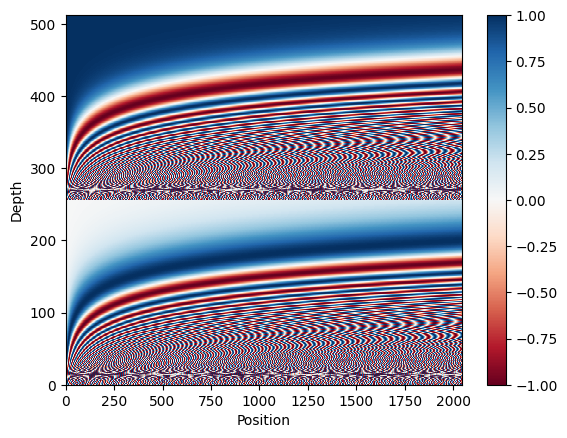

In [ ]:
pos_encoding = positional_encoding(length=2048, depth=512)

print(pos_encoding.shape)


plt.pcolormesh(pos_encoding.numpy().T, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

(0.0, 1.0)

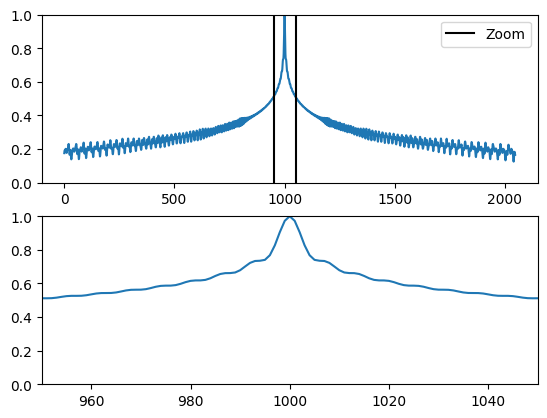

In [ ]:
pos_encoding /= tf.norm(pos_encoding, axis=1, keepdims=True)
p = pos_encoding[1000]

dots = tf.einsum('pd,d -> p', pos_encoding, p)

plt.subplot(2,1,1)
plt.plot(dots)

plt.ylim([0,1])
plt.plot([950, 950, float('nan'), 1050, 1050],
         [0,1,float('nan'),0,1], color='k', label='Zoom')
plt.legend()
plt.subplot(2,1,2)
plt.plot(dots)
plt.xlim([950, 1050])
plt.ylim([0,1])

Lets create a Position Embedding keras layer, formalizing this.

In [ ]:
class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, d_model):
    super().__init__()
    self.d_model = d_model
    self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True)
    self.pos_encoding = positional_encoding(length=2048, depth=d_model)

  #identifies positions of padding tokens
  def compute_mask(self, *args, **kwargs):
    return self.embedding.compute_mask(*args, **kwargs)

  def call(self, x):
    length = tf.shape(x)[1]
    x = self.embedding(x)

    #Set the relative scale of embedding and pos encoding in transformers
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    return x

#2 embeddings
embed_pt = PositionalEmbedding(vocab_size=tokenizers.pt.get_vocab_size().numpy(), d_model=512)
embed_en = PositionalEmbedding(vocab_size=tokenizers.en.get_vocab_size().numpy(), d_model=512)

In [ ]:
pt_emb = embed_pt(pt)
en_emb = embed_en(en)

pt_emb.shape, en_emb.shape

(TensorShape([32, 55, 512]), TensorShape([32, 55, 512]))

In [ ]:
en_emb._keras_mask

<tf.Tensor: shape=(32, 55), dtype=bool, numpy=
array([[ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]])>

**Adding and Normalization and Attention**

Add and Norm layers, ensures MHA layers compute change in embeddings that need to be added in order to encode contextual information. Res connections provide a direct path for the gradient and ensures vectors are updated by attention, instead of replaced and normalization maintains a reasonable scale.

Add Layer ensures keras masks are propagated. + operator does not.

Lets implement the multi head attention layer.

In [ ]:
class BaseAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

Recall the query sequence is the sequence being processed, the sequence doing the attending. The key sequence (key values) will be the context sequence being attended to. The output has the same  shape as the query sequence. This is like a dictionary lookup.

Consider a python dictionary with 3 keys and 3 values being passed a single query. The query is what we are trying to find, the key is what sort of info the dictionary has, the value is that information. The query either has a matching key or it doesn't. Now imagine a fuzzy dictionary where the keys dont have to match perfectly. If you looked up d["species"] in the dictionary above, maybe you'd want it to return "pickup" since thats the best match for the query.

Attention doesnt just look for the best key, it combines the values based on how well the query matches each key. Instead of doing a hash lookup, the attention combines the query and key vector to obtain and attention score. The layer returns the average across all values, weighted by the attention scores.

Each location, the query sequence provides a query vector. The context sequence acts as the dictionary. At each location in the context sequence provides a key and value vector. The input vectors are not used directly as theres a dense layers to project the input vectors before using them.

In [ ]:
class CrossAttention(BaseAttention):
  #Inherit from base attention
  def call(self, x, context):
    attn_output, attn_scores = self.mha(
        query=x,
        key=context,
        value=context,
        return_attention_scores=True)

    self.last_attn_scores = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

Test it on sample inputs

In [ ]:
sample_ca = CrossAttention(num_heads=2, key_dim=512)

print(pt_emb.shape)
print(en_emb.shape)
print(sample_ca(en_emb, pt_emb).shape)

(32, 55, 512)
(32, 55, 512)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'query' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'key' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'value' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


(32, 55, 512)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'cross_attention' (of type CrossAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


**Self-attention**

This layer is responsible for processing the context sequence

In [ ]:
class GlobalSelfAttention(BaseAttention):
  #no init as no new attributes
  def call(self, x):
    attn_output = self.mha(query=x, value=x, key=x)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

sample_gsa = GlobalSelfAttention(num_heads=2, key_dim=512)

print(pt_emb.shape)
print(sample_gsa(pt_emb).shape)

(32, 55, 512)
(32, 55, 512)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'global_self_attention' (of type GlobalSelfAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


**Masked Self Attention**

Since transformers are autoregressive, the models ensure that the output only depends on previous sequence elements.

For a causal convolution we just need to pad the input and shift the output so it alligns correctly (use layers.Conv1D(padding='causal')

Mask is taken care of automatically when saying use_causal_mask = True

In [ ]:
class CausalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x,
        use_causal_mask = True)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [ ]:
sample_csa = CausalSelfAttention(num_heads=2, key_dim=512)

print(en_emb.shape)
print(sample_csa(en_emb).shape)

(32, 55, 512)
(32, 55, 512)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'causal_self_attention' (of type CausalSelfAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


The output for early sequence elements do not depend on later elements, so id doesnt matter if you trim elements before or after applying the layer.

In [ ]:
out1 = sample_csa(embed_en(en[:, :3]))
out2 = sample_csa(embed_en(en))[:, :3]

tf.reduce_max(abs(out1 - out2)).numpy()

7.1525574e-07

**Feed forward network**

In [ ]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),
        tf.keras.layers.Dense(d_model),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    x = self.layer_norm(x)
    return x

In [ ]:
sample_ffn = FeedForward(512, 2048)

print(en_emb.shape)
print(sample_ffn(en_emb).shape)

(32, 55, 512)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'sequential' (of type Sequential) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


(32, 55, 512)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'feed_forward' (of type FeedForward) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


**Encoder**

Now lets build the encoder

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, *, d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()

    self.self_attention = GlobalSelfAttention(
        num_heads = num_heads,
        key_dim = d_model,
        dropout = dropout_rate
    )

    self.ffn = FeedForward(d_model, dff)

  def call(self, x):
    x = self.self_attention(x)
    x = self.ffn(x)
    return x

In [ ]:
sample_encoder_layer = EncoderLayer(d_model=512, num_heads=8, dff=2048)

print(pt_emb.shape)
print(sample_encoder_layer(pt_emb).shape)

(32, 55, 512)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'global_self_attention_1' (of type GlobalSelfAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'sequential_1' (of type Sequential) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'feed_forward_1' (of type FeedForward) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(

(32, 55, 512)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'encoder_layer' (of type EncoderLayer) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [ ]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads,
               dff, vocab_size, dropout_rate=0.1):
    super().__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(
        vocab_size=vocab_size, d_model=d_model)

    self.enc_layers = [
        EncoderLayer(d_model=d_model,
                     num_heads=num_heads,
                     dff=dff,
                     dropout_rate=dropout_rate)
        for _ in range(num_layers)]

    self.dropout = tf.keras.layers.Dropout(dropout_rate)

  def call(self, x):
    x = self.pos_embedding(x)

    x = self.dropout(x)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x)

    return x

In [ ]:
sample_encoder = Encoder(num_layers=4,
                         d_model=512,
                         num_heads=8,
                         dff=2048,
                         vocab_size=8500)

sample_encoder_output = sample_encoder(pt, training=False)

print(pt.shape)
print(sample_encoder_output.shape)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'global_self_attention_2' (of type GlobalSelfAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'sequential_2' (of type Sequential) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'feed_forward_2' (of type FeedForward) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(

(32, 55)
(32, 55, 512)


**Decoder**

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, *, d_model, num_heads, dff, dropout_rate=0.1):
    super(DecoderLayer, self).__init__()

    self.causal_self_attention = CausalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.cross_attention = CrossAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x, context):
    x = self.causal_self_attention(x=x)
    x = self.cross_attention(x=x, context=context)

    self.last_attn_scores = self.cross_attention.last_attn_scores

    x = self.ffn(x)
    return x

In [ ]:
sample_decoder_layer = DecoderLayer(d_model=512, num_heads=8, dff=2048)

sample_decoder_layer_output = sample_decoder_layer(
    x=en_emb, context=pt_emb)

print(en_emb.shape)
print(pt_emb.shape)
print(sample_decoder_layer_output.shape)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'causal_self_attention_1' (of type CausalSelfAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'cross_attention_1' (of type CrossAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'sequential_6' (of type Sequential) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings

(32, 55, 512)
(32, 55, 512)
(32, 55, 512)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'decoder_layer' (of type DecoderLayer) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [ ]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads, dff,
               vocab_size, dropout_rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size,
                                            d_model=d_model)

    self.dropout = tf.keras.layers.Dropout(dropout_rate)

    self.dec_layers = [DecoderLayer(d_model=d_model, num_heads=num_heads,
                                    dff=dff, dropout_rate=dropout_rate)
                      for _ in range(num_layers)]

    self.last_attn_scores = None

  def call(self, x, context):

    x = self.pos_embedding(x)

    x = self.dropout(x)

    for i in range(self.num_layers):
      x = self.dec_layers[i](x, context)

    self.last_attn_scores = self.dec_layers[-1].last_attn_scores

    return x

In [ ]:
sample_decoder = Decoder(num_layers=4,
                         d_model=512,
                         num_heads=8,
                         dff=2048,
                         vocab_size=8000)

output = sample_decoder(
    x=en,
    context=pt_emb)

print(en.shape)
print(pt_emb.shape)
print(output.shape)

sample_decoder.last_attn_scores.shape

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'causal_self_attention_2' (of type CausalSelfAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'cross_attention_2' (of type CrossAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'sequential_7' (of type Sequential) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings

(32, 55)
(32, 55, 512)
(32, 55, 512)


TensorShape([32, 8, 55, 55])

Now time to build the actual transformers

**Transformer**

In [ ]:
class Transformer(tf.keras.Model):
  def __init__(self, *, num_layers, d_model, num_heads, dff,
               input_vocab_size, target_vocab_size, dropout_rate=0.1):
    super().__init__()
    self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=input_vocab_size, dropout_rate=dropout_rate)

    self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=target_vocab_size, dropout_rate=dropout_rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inputs):

    context, x = inputs

    context = self.encoder(context)
    x = self.decoder(x, context)

    logits = self.final_layer(x)

    try:
      #Drop the mask so it doesnt effect the losses
      del logits._keras_mask
    except AttributeError:
      pass

    return logits

##Training

In [ ]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1

transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=tokenizers.pt.get_vocab_size().numpy(),
    target_vocab_size=tokenizers.en.get_vocab_size().numpy(),
    dropout_rate=dropout_rate)

transformer.summary()

Model: "transformer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ encoder_1 (Encoder)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_1 (Decoder)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_38 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Test the model

In [ ]:
output = transformer((pt, en))

print(en.shape)
print(pt.shape)
print(output.shape)

attn_scores = transformer.decoder.dec_layers[-1].last_attn_scores
print(attn_scores.shape)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'global_self_attention_6' (of type GlobalSelfAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'sequential_11' (of type Sequential) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'feed_forward_11' (of type FeedForward) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.war

(32, 55)
(32, 55)
(32, 55, 7010)
(32, 8, 55, 55)


Let set up the optimizer, we are going to schedule our learning rate according to the transformer paper.

lrate = d_model ^ (-0.5) * min(step_num ^ (-0.5), step_num x warmup_steps ^ (-1.5))

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4800):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

Test this

Text(0.5, 0, 'Train Step')

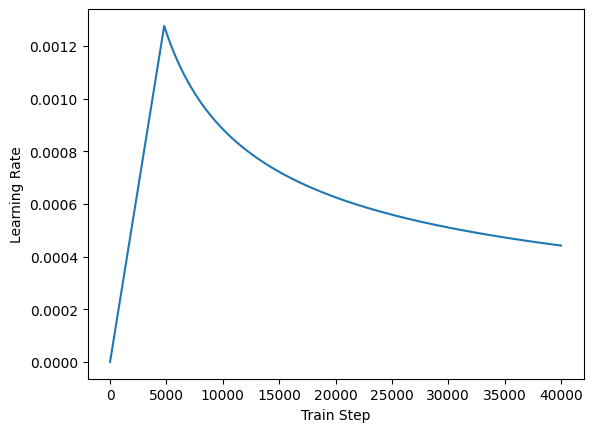

In [ ]:
plt.plot(learning_rate(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

Set up the loss and metrics. Since the target sequences are padded, it is important to apply a padding mask when calculating the loss. Use the cross entropy loss function.

In [ ]:
def masked_loss(label, pred):
  mask = label != 0
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')
  loss = loss_object(label, pred)

  mask = tf.cast(mask, dtype=loss.dtype)
  loss *= mask

  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss

def masked_accuracy(label, pred):
  pred = tf.argmax(pred, axis=2)
  label = tf.cast(label, pred.dtype)
  match = label == pred

  mask = label != 0
  match = match & mask

  match = tf.cast(match, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(match)/tf.reduce_sum(mask)

Train

In [ ]:
transformer.compile(
    loss=masked_loss,
    optimizer=optimizer,
    metrics=[masked_accuracy])

history = transformer.fit(train_batches,
                          epochs=20,
                          validation_data=val_batches)

Epoch 1/20
   2/1619 ━━━━━━━━━━━━━━━━━━━━ 1:41:28 4s/step - loss: 8.8841 - masked_accuracy: 0.0000e+00  

KeyboardInterrupt: 

##Predictions and Inference

The following steps are used.

Encode the input sequence using the portuguese tokenizer. This is the encoder input.

The decoder input is initialized to the [START] token.

Calculate the padding masks and the look ahead masks.

The decoder then outputs the predictions by looking at the encoder output and its own output (self attention).

Concatenate the predicted token to the decoder input and pass it to the decoder

Here, the decoder predicts the next token based on the previous token it predicted.

In [ ]:
class Translator(tf.Module):
  def __init__(self, tokenizers, transformer):
    self.tokenizers = tokenizers
    self.transformer = transformer

  def __call__(self, sentence, max_length=MAX_TOKENS):
    #Inp seq is portugueuse so add start and end token
    assert isinstance(sentence, tf.Tensor)
    if len(sentence.shape) == 0:
      sentence = sentence[tf.newaxis]

    sentence = self.tokenizers.pt.tokenize(sentence)
    sentence = sentence.to_tensor()

    encoder_input = sentence

    #Initialize will english start token
    start_end = self.tokenizers.en.tokenize([''])[0]
    start = start_end[0][tf.newaxis]
    end = start_end[1][tf.newaxis]

    #Tensor array instead of python func so dynamic loop can be traced
    #by tf function
    output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
    output_array = output_array.write(0, start)

    for i in tf.range(max_length):
      output = tf.transpose(output_array.stack())
      predictions = self.transformer([encoder_input, output], training=False)

      #Select the last token from the seq dimension
      predictions = predictions[:, -1:, :]

      prediction_id = tf.argmax(predictions, axis=-1)

      #Concatenate the pred id to the output
      output_array = output_array.write(i+1, prediction_id[0])

      if tf.equal(prediction_id, end):
        break

    output = tf.transpose(output_array.stack())
    text = tokenizers.en.detokenize(output)[0]

    tokens = tokenizers.en.lookup(output)[0]

    #tf.function prevents us from using attn weights calculated
    #on last iteration of the loop so recalculate them outside the loop

    self.transformer([encoder_input, output[:, :-1]], training=False)
    attn_weights = self.transformer.decoder.last_attn_scores

    return text, tokens, attn_weights

This function uses an unrolled loop, not a dynamic loop.

In [ ]:
translator = Translator(tokenizers, transformer)

def print_translation(sentence, tokens, ground_truth):
  print(f'{"Input:":15s}: {sentence}')
  print(f'{"Prediction":15s}: {tokens.numpy().decode("utf-8")}')
  print(f'{"Ground truth":15s}: {ground_truth}')

Examples

In [ ]:
sentence = 'este é um problema que temos que resolver.'
ground_truth = 'this is a problem we have to solve .'

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : este é um problema que temos que resolver.
Prediction     : approaching massive kitchen planning represent grave generate intimate represent kitchen meaning meaning meaning meaningsion failure topics prey professors professors professors meaning meaning topics least letters letters letters letters letters letters coveredsters domain generatefish shame immediately least professors contains profits letters letters letters education sector generate education grave beings generate effective blast generate blast professors professors professors 48 stone sections seem professors 400 professors letters professors letters inventor times chile chile stone stone stone belong professors represents calculated calculated kiss effective attention attention chile chile chile inventor terribly terriblytendedcisttendedcist profits billion chile13 chile chile chile chile kissnces chile kiss profits judgment chile chile chile kiss profits inventor chile chile chile represents represents 

In [ ]:
sentence = 'os meus vizinhos ouviram sobre esta ideia.'
ground_truth = 'and my neighboring homes heard about this idea .'

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : os meus vizinhos ouviram sobre esta ideia.
Prediction     : inventor regime regime grave chip represent grave protocol kenya meaning meaning meaning meaning meaningsion failure topics prey professors professors seem seem giving professors contains give professors letters letters letters letters coveredsters domain generate least shame last letters education professors professors professors letters letters education sector generate education grave beingsx kiss generate blast generate blastws professors stone 48 stone times nest professors professors letters professors letters inventor times chile chile stone stone stone belong professors stone grave represents calculated kiss net professors grave chile chile inventor chile terriblytendedcisttendedcist profits billion chile chile13 chile chile chile chile kiss profits billion chile chile chile chile chile chile kiss chile kiss reflection notice region rent judgment represents catch generate generate rent kiss notice
Grou

In [ ]:
sentence = 'vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.'
ground_truth = "so i'll just share with you some stories very quickly of some magical things that have happened."

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.
Prediction     : approaching massive kitchen planning represent grave sensitive atomic helps neighborhoods meaning meaning meaning meaningsion net attention bread sensitive neighborhoods sanitation neighborhoods simulation professors contains give professors letters meaning topics leaststerssterssters shame shame last letters educationana professors professors professors letters letters education sector generate education grave beingsx kiss generate blast generate blast professors professors 48 stone sections seem professors 400 professors 400 letters inventor times countless chile chile stone stone stone belong professors represents calculated calculated kiss sms tip grave represents professors chile inventor chile terriblytendedcisttendedcist profits billion chile chile13 chile chile chile chile kiss profits billion chile chile chile chile chile chile kiss prof

Create attention plots

In [ ]:
sentence = 'este é o primeiro livro que eu fiz.'
ground_truth = "this is the first book i've ever done."

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : este é o primeiro livro que eu fiz.
Prediction     : approaching massive kitchen planning represent grave generate intimate represent kitchen meaning meaning meaning meaningsion failure topics prey professors professors professors meaning meaning topics least letters letters letters letters letters letters coveredsters domain generatefish shame immediately least professors contains drops professors letters letters education sector generate education grave beings generate effective degree degree represent professors professors professors stone 48 stone times nest professors 400 letters professors letters inventor times chile chile stone stone stone belong professors represents calculated calculated kiss effective attention attention chile chile chile inventor chile terriblytendedcisttendedcist profits billion chile13 chile chile chile chile kissnces chile kissinated chile chile chile chile chile kiss profits inventor chile chile represents represents represents represen

In [ ]:
def plot_attention_head(in_tokens, translated_tokens, attention):

  # The model didn't generate `<START>` in the output. Skip it.
  translated_tokens = translated_tokens[1:]

  ax = plt.gca()
  ax.matshow(attention)
  ax.set_xticks(range(len(in_tokens)))
  ax.set_yticks(range(len(translated_tokens)))

  labels = [label.decode('utf-8') for label in in_tokens.numpy()]
  ax.set_xticklabels(
      labels, rotation=90)

  labels = [label.decode('utf-8') for label in translated_tokens.numpy()]
  ax.set_yticklabels(labels)

(128, 11)
tf.Tensor(
[b'[START]' b'este' b'e' b'o' b'primeiro' b'livro' b'que' b'eu' b'fiz'
 b'.' b'[END]'], shape=(11,), dtype=string)
tf.Tensor(
[b'[START]' b'approaching' b'massive' b'kitchen' b'planning' b'represent'
 b'grave' b'generate' b'intimate' b'represent' b'kitchen' b'meaning'
 b'meaning' b'meaning' b'meaning' b'##sion' b'failure' b'topics' b'prey'
 b'professors' b'professors' b'professors' b'meaning' b'meaning' b'topics'
 b'least' b'letters' b'letters' b'letters' b'letters' b'letters'
 b'letters' b'covered' b'##sters' b'domain' b'generate' b'##fish' b'shame'
 b'immediately' b'least' b'professors' b'contains' b'drops' b'professors'
 b'letters' b'letters' b'education' b'sector' b'generate' b'education'
 b'grave' b'beings' b'generate' b'effective' b'degree' b'degree'
 b'represent' b'professors' b'professors' b'professors' b'stone' b'48'
 b'stone' b'times' b'nest' b'professors' b'400' b'letters' b'professors'
 b'letters' b'inventor' b'times' b'chile' b'chile' b'stone' b'stone'

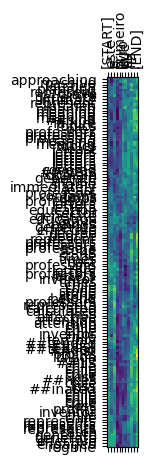

In [ ]:
head = 0

attention_heads = tf.squeeze(attention_weights, 0)
attention = attention_heads[head]
print(attention.shape)

#These are the input portuguese tokens
in_tokens = tf.convert_to_tensor([sentence])
in_tokens = tokenizers.pt.tokenize(in_tokens).to_tensor()
in_tokens = tokenizers.pt.lookup(in_tokens)[0]
print(in_tokens)

#Here are the english outputs

print(translated_tokens)

plot_attention_head(in_tokens, translated_tokens, attention)

Lets plot the attention weights

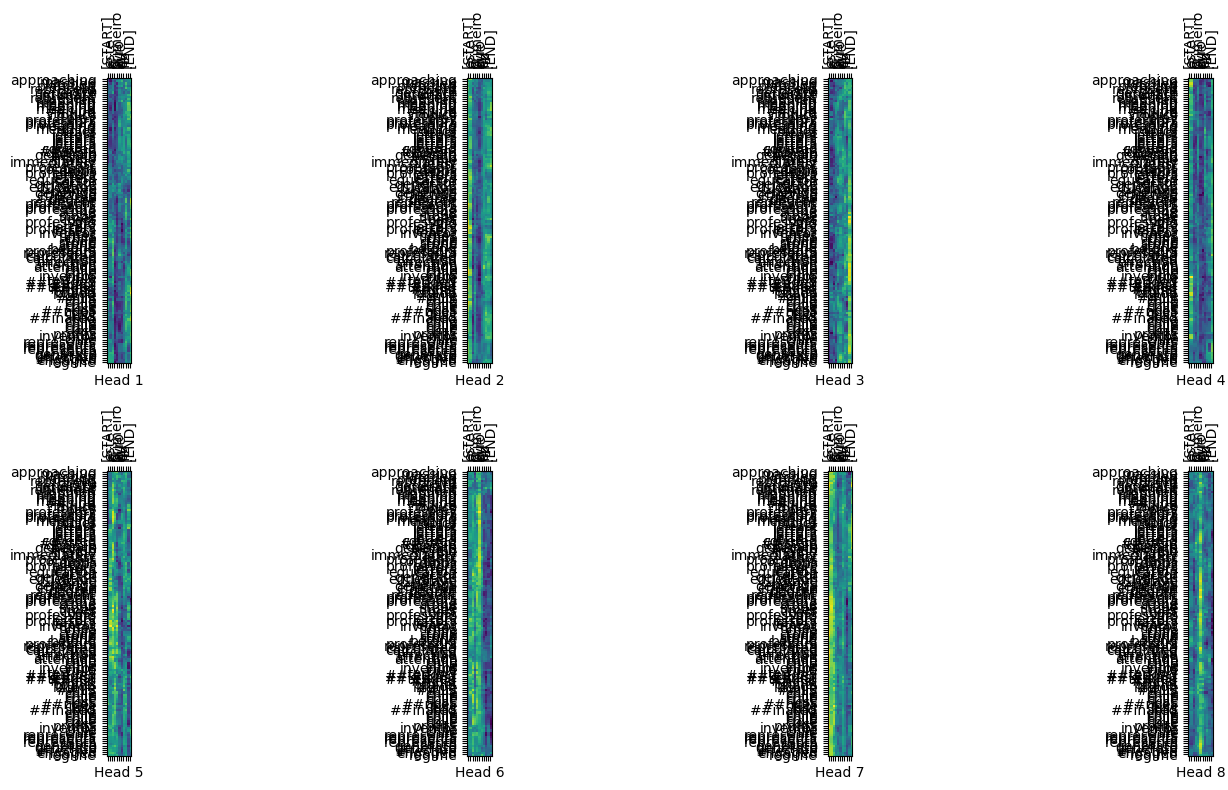

In [ ]:
def plot_attention_weights(sentence, translated_tokens, attention_heads):
  in_tokens = tf.convert_to_tensor([sentence])
  in_tokens = tokenizers.pt.tokenize(in_tokens).to_tensor()
  in_tokens = tokenizers.pt.lookup(in_tokens)[0]

  fig = plt.figure(figsize=(16, 8))

  for h, head in enumerate(attention_heads):
    ax = fig.add_subplot(2, 4, h+1)

    plot_attention_head(in_tokens, translated_tokens, head)

    ax.set_xlabel(f'Head {h+1}')

  plt.tight_layout()
  plt.show()

plot_attention_weights(sentence,
                       translated_tokens,
                       attention_weights[0])

This model can handle unfamiliar words. Neither triceratops nor encyclopedia are in the input dataset but the model attempts to transliterate them even without a shared vocabular.

Input:         : Eu li sobre triceratops na enciclopédia.
Prediction     : inventor regime grave 400 shame represent grave protocol kenya meaning meaning meaning meaning meaningsion failure topics net indian failure seem seem giving professors contains give professors letters meaning topics leaststerssterssters shame shame last letters educationana professors professors professors letters letters education sector generate education grave beings generate effective degreences won inventor crop dropping crop 400 seem professors 400 seem professors 400 letters inventor times countless chile chile stone stone stone belong professors represents calculated calculated chile kiss net chile chile chile chile inventorge terriblytendedcisttendedcist profits billion chile13 chile chile chile chile chile kiss profits billion chile chile chile chile chile chile kiss profits inventor chile chile represents represents represents represents catch generate generate rent kiss released
Ground truth   : I r

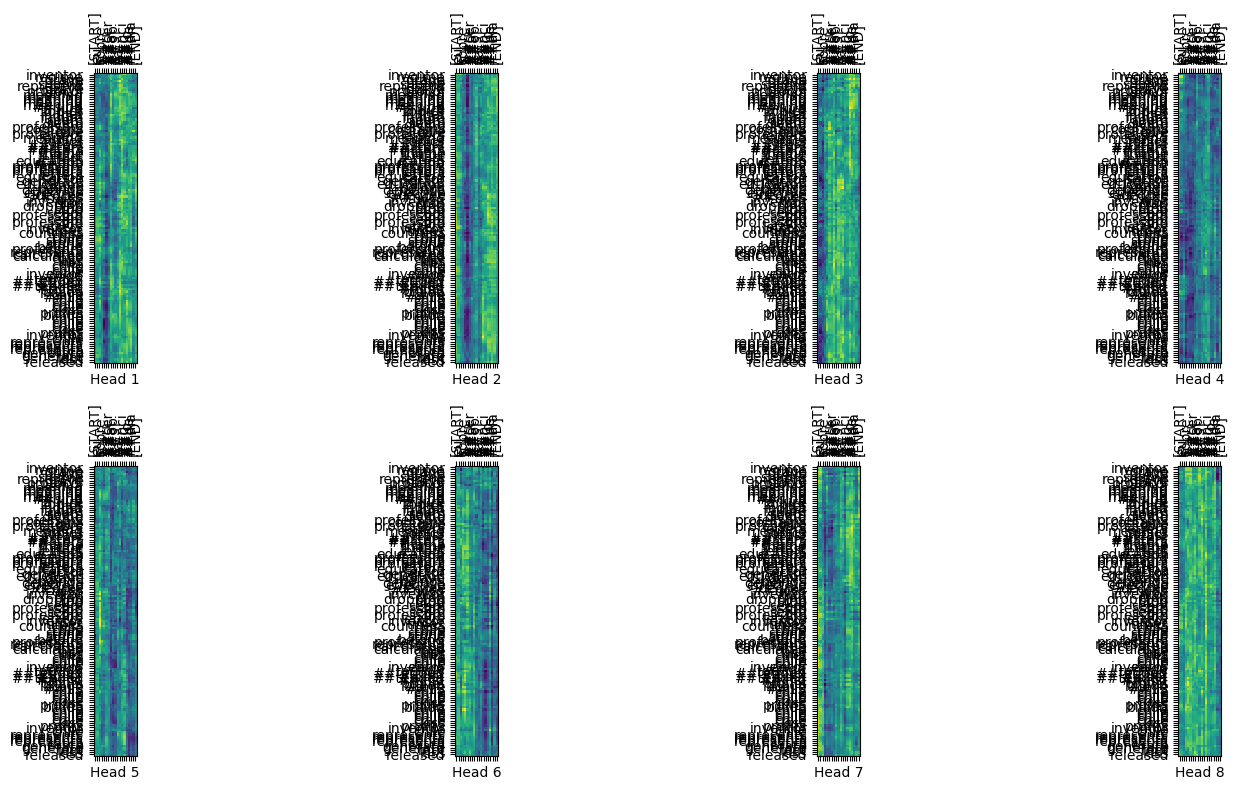

In [ ]:
sentence = 'Eu li sobre triceratops na enciclopédia.'
ground_truth = 'I read about triceratops in the encyclopedia.'

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

plot_attention_weights(sentence, translated_tokens, attention_weights[0])

##Exporting and Saving

https://www.tensorflow.org/guide/saved_model

In [ ]:
class ExportTranslator(tf.Module):
  def __init__(self, translator):
    self.translator = translator

  @tf.function(input_signature=[tf.TensorSpec(shape=[], dtype=tf.string)])
  def __call__(self, sentence):
    (result, tokens, attention_weights) = self.translator(
        sentence, max_length=MAX_TOKENS)

    return result

In [ ]:
translator = ExportTranslator(translator)

The predictions are deterministic since model is decoding predictions using tf.argmax, so the original model and the reloaded should give identical predictions.

In [ ]:
translator('este é o primeiro livro que eu fiz.').numpy()

Save

In [ ]:
tf.saved_model.save(translator, export_dir='translator')
reloaded = tf.saved_model.load('translator')
reloaded('este é o primeiro livro que eu fiz.').numpy()